# Example of DOV search methods for observations (observaties)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/DOV-Vlaanderen/pydov/master?filepath=docs%2Fnotebooks%2Fsearch_observaties.ipynb)

## Use cases explained below
* Get observations in a bounding box
* Get observations with specific properties
* Get observations in a bounding box based on specific properties
* Select observations in a municipality and return depth
* Get observations based on fields not available in the standard output dataframee

In [1]:
import os
os.environ['PYDOV_BASE_URL'] = 'https://oefen.dov.vlaanderen.be/'

In [2]:
%matplotlib inline
import inspect, sys
import warnings; warnings.simplefilter('ignore')

In [3]:
# check pydov path
import pydov

## Get information about the datatype 'Observatie'

In [4]:
from pydov.search.observatie import ObservatieSearch
observatie = ObservatieSearch()

A description is provided for the 'Observatie' datatype:

In [5]:
observatie.get_description()

'Observaties zijn gekoppeld aan een monster en geven de waarde van een kenmerk/parameter weer die in een laboratorium of in het veld bepaald kunnen zijn. De observaties kunnen zeer divers zijn variërend van een kwantitatieve waarde uit een meting zoals watergehalte (%), kwalitatieve waarde uit een beschrijving of classificatie zoals grondsoort, gecodeerde waarde, zoals kalkreactie met HCL (ja/nee), een meetreeks zoals een korrelverdeling, een textuurmeting, een tijdmeetreeks zoals de temperatuurmeting met de gazondolk. De geografische ligging (X en Y (mL72) nemen ze over van het gekoppeld monster.  De gegevens van de observaties kunnen worden geëxporteerd in een rapport.'

The different fields that are available for objects of the 'Observatie' datatype can be requested with the get_fields() method:

In [6]:
fields = observatie.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

id
pkey_observatie
pkey_parent
parameter
parametergroep
observatietype
detectieconditie
resultaat
eenheid
fenomeentijd
resultaattijd
methode
uitvoerder
diepte_van_m
diepte_tot_m
herkomst
opdracht
geom


You can get more information of a field by requesting it from the fields dictionary:

* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field
* *codelist*: optionally, a codelist that describes the possible values of this field

Alternatively, you can list all the fields and their details by inspecting the `get_fields()` output or the search instance itself in a notebook:

In [7]:
observatie

## Example use cases

### Get observations in a bounding box

Get data for all the observations that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [8]:
from pydov.util.location import Within, Box

df = observatie.search(location=Within(Box(114000, 172310, 114005, 172315, epsg=31370)), max_features = 10)
df.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,4.5,4.75,Onderkenning-grondsoort,Grondsoort volgens GEO-BGGG (Grondsoort BGGG),NaN,sterk kalkh. of schelph. zandh. leem,-,Classificatie volgens de norm,VO - Afdeling Geotechniek,LABO
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,4.5,4.75,Onderkenning - proeven,Consistentiegrenzen - Uitrolgrens (Consistenti...,NaN,25,%,Onbekend,VO - Afdeling Geotechniek,LABO
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,4.5,4.75,Onderkenning - proeven,Gehalte Organische stoffen (Gehalte Organische...,NaN,0.4,%,Chemische reactie met waterstofperoxide,VO - Afdeling Geotechniek,LABO
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,4.5,4.75,Onderkenning - proeven,Gehalte Kalkachtige stoffen (Gehalte Kalkachti...,NaN,69.8,%,Chemische reactie met waterstofchloride,VO - Afdeling Geotechniek,LABO
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,51.7,%,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO


The dataframe contains several observations made at the same location

Using the *pkey_observatie* field one can request the details of these obsevrations in a webbrowser:

In [9]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

https://oefen.dov.vlaanderen.be/data/observatie/2022-1439872
https://oefen.dov.vlaanderen.be/data/observatie/2022-6538564
https://oefen.dov.vlaanderen.be/data/observatie/2022-6538563
https://oefen.dov.vlaanderen.be/data/observatie/2022-5629071
https://oefen.dov.vlaanderen.be/data/observatie/2022-2807310
https://oefen.dov.vlaanderen.be/data/observatie/2022-4900100
https://oefen.dov.vlaanderen.be/data/observatie/2022-3535597
https://oefen.dov.vlaanderen.be/data/observatie/2022-1667272
https://oefen.dov.vlaanderen.be/data/observatie/2022-2761922
https://oefen.dov.vlaanderen.be/data/observatie/2022-3489734


### Get observations with specific properties

Next to querying observations based on their geographic location within a bounding box, we can also search for observations matching a specific set of properties. For this we can build a query using a combination of the 'Observatie' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [10]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes2'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all observations concerning the parameter "Watergehalte (watergehalte)":

In [11]:
from owslib.fes2 import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='parameter',
                          literal='Watergehalte (watergehalte)')
df = observatie.search(query=query, max_features = 10)

df.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst
0,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-01-10,9.0,9.75,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,27.0,%,Onbekend,NaN,LABO
1,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-01-10,9.0,9.75,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,27.0,%,Onbekend,NaN,LABO
2,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2022-04-08,2.5,3.00,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,37.1,%,Gewichtsverlies na drogen in droogstoof,NaN,LABO
3,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2022-04-08,2.5,3.00,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,37.1,%,Gewichtsverlies na drogen in droogstoof,NaN,LABO
4,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2022-04-08,5.7,5.97,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,32.1,%,Gewichtsverlies na drogen in droogstoof,NaN,LABO


Once again we can use the *pkey_observatie* as a permanent link to the information of these observations:

In [12]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

https://oefen.dov.vlaanderen.be/data/observatie/2025-43639382
https://oefen.dov.vlaanderen.be/data/observatie/2022-43603882
https://oefen.dov.vlaanderen.be/data/observatie/2025-43639010
https://oefen.dov.vlaanderen.be/data/observatie/2025-43639691
https://oefen.dov.vlaanderen.be/data/observatie/2022-43603633
https://oefen.dov.vlaanderen.be/data/observatie/2022-43638564
https://oefen.dov.vlaanderen.be/data/observatie/2022-37800230
https://oefen.dov.vlaanderen.be/data/observatie/2025-43567962
https://oefen.dov.vlaanderen.be/data/observatie/2025-43603463
https://oefen.dov.vlaanderen.be/data/observatie/2022-37800100


### Get observations in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the observations within a bounding box that have specific properties.

The following example requests the observations where the parameter 'Watergehalte (watergehalte)' is greater than 30 and within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [13]:
from owslib.fes2 import PropertyIsGreaterThanOrEqualTo, And

query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='30'),
            PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])

df = observatie.search(
    location=Within(Box(114000, 172310, 114005, 172315, epsg=31370)),
    query=query,
    max_features = 10
    )

df.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,51.7,%,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-01-09,NaN,NaN,Volumemassa-watergehalte,Watergehalte (watergehalte),NaN,36.3,%,Gewichtsverlies na drogen in droogstoof,VO - Afdeling Geotechniek,LABO


We can look at one of theobservations in a webbrowser using its *pkey_observatie*:

In [14]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

https://oefen.dov.vlaanderen.be/data/observatie/2022-2533717
https://oefen.dov.vlaanderen.be/data/observatie/2022-2761922


### Select observations with specific conditions and return the results

We can limit the columns in the output dataframe by specifying the *return_fields* parameter in our search.

In this example we query all the observations that have a value (resultaat) greater than 10 for parameter 'Watergehalte (watergehalte)' and	return its value (resultaat):

In [15]:
query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='10'),
            PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])

df = observatie.search(query=query,
                       return_fields=('resultaat',),
                       max_features=10)
df.head()

[000/001] .


,resultaat
0,27.0
1,27.0
2,37.1
3,37.1
4,32.1


In [16]:
df.describe()

,resultaat
count,10
unique,6
top,27.0
freq,3


By discarding the observations with a resultaat less than 50, we get a different result:

In [17]:
df[df.resultaat.astype(float) < 50.0].describe()

,resultaat
count,10
unique,6
top,27.0
freq,3


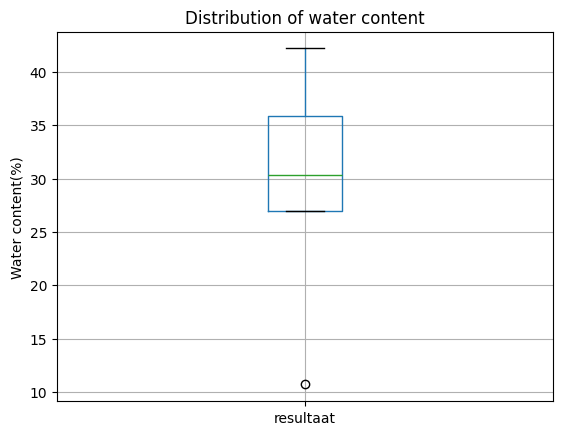

In [18]:
ax = df[df.resultaat.astype(float) < 50.0].astype(float).boxplot()
ax.set_ylabel("Water content(%)");
ax.set_title("Distribution of water content");

### Get observations based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select observations as illustrated below.

For example, make a selection of the observations that have an 'opdracht':

In [19]:
from owslib.fes2 import Not
from owslib.fes2 import PropertyIsNull

query = Not([PropertyIsNull(propertyname='opdracht')])

df = observatie.search(query=query, max_features = 10,
                   return_fields=('pkey_observatie', 'opdracht'))
df.head()

[000/001] .


,pkey_observatie,opdracht
0,https://oefen.dov.vlaanderen.be/data/observati...,Bodemkoolstofmonitoringnetwerk Cmon: staalname...
1,https://oefen.dov.vlaanderen.be/data/observati...,Bodemkoolstofmonitoringnetwerk Cmon leesrechte...
2,https://oefen.dov.vlaanderen.be/data/observati...,Bodemkoolstofmonitoringnetwerk Cmon leesrechte...
3,https://oefen.dov.vlaanderen.be/data/observati...,Bodemkoolstofmonitoringnetwerk Cmon: staalname...
4,https://oefen.dov.vlaanderen.be/data/observati...,Bodemkoolstofmonitoringnetwerk Cmon leesrechte...


### Select observations with extra details

We can ask extra info from an observation from the XML. In this example we want the details of an observation

In [20]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, ObservatieDetails

observatie = ObservatieSearch(
    objecttype=Observatie.with_extra_fields(ObservatieDetails)
)

df = observatie.search(max_features=10)
df.head()

list(df.pkey_observatie)

[000/001] .
[000/010] ..........


['https://oefen.dov.vlaanderen.be/data/observatie/2022-1301794',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-1301912',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-1664565',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-1664759',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-1673386',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-2029252',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-2393623',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-2393624',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-2394049',
 'https://oefen.dov.vlaanderen.be/data/observatie/2022-2394282']

### Get observations with data from the subtype 'ObservatieHerhaling'

There are different subtypes available within observations search: 'ObservatieHerhaling'



In [21]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, ObservatieHerhaling
from owslib.fes2 import PropertyIsLike

observatie = ObservatieSearch(
    objecttype=Observatie.with_subtype(ObservatieHerhaling))
query = PropertyIsLike(propertyname='pkey_observatie',
                       literal='%2022-11963810%')
df = observatie.search(query=query, max_features = 10)
df.head()

[000/001] .
[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst,herhaling_aantal,herhaling_minimum,herhaling_maximum,herhaling_standaardafwijking
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemdiep...,2022-02-17,NaN,NaN,Bodem_terrein,Strooisellaag of viltlaag - dikte (strooisella...,NaN,1.0,cm,Cmon staalnameprotocol,NaN,VELD,32,1.0,1.0,0.0


### Get observations with data from the subtype 'SecundaireParameter'

Another available subtype within observations search: 'SecundaireParameter'

In [22]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, SecundaireParameter
from owslib.fes2 import PropertyIsLike

observatie = ObservatieSearch(
    objecttype=Observatie.with_subtype(SecundaireParameter))
query = PropertyIsLike(propertyname='pkey_observatie',
                       literal='%2019-000555%')
df = observatie.search(query=query, max_features = 10)
df.head()

[000/001] .
[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst,secundaireparameter_parameter,secundaireparameter_resultaat,secundaireparameter_eenheid
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemdiep...,2015-12-10,NaN,NaN,Bodem_fysisch_vocht,Ksat (ksat),NaN,0.00E00,m/s,Ksat Open-end-methode,NaN,VELD,temp_bodem,5.0,°C
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemdiep...,2015-12-10,NaN,NaN,Bodem_fysisch_vocht,Ksat (ksat),NaN,0.00E00,m/s,Ksat Open-end-methode,NaN,VELD,proefvlak_diepte,60.0,cm
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/bodemdiep...,2015-12-10,NaN,NaN,Bodem_fysisch_vocht,Ksat (ksat),NaN,0.00E00,m/s,Ksat Open-end-methode,NaN,VELD,temp_water,5.0,°C


## Visualize results

Using Geopandas GeoDataFrame, we can easily display the results of our search on a map.

In [23]:
import geopandas as gpd

query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='10'),
             PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])

df = observatie.search(query=query, location=Within(Box(100000, 100000, 500000, 500000, epsg=31370)),
                       return_fields=('pkey_observatie','resultaat','geom'), max_features = 100)

[000/001] .


In [24]:
df

,pkey_observatie,resultaat,geom
0,https://oefen.dov.vlaanderen.be/data/observati...,25.6,POINT (134549.45 192498.74)
1,https://oefen.dov.vlaanderen.be/data/observati...,58.0,POINT (119850.55 188966.56)
2,https://oefen.dov.vlaanderen.be/data/observati...,17.7,POINT (137016.83 193996.39)
3,https://oefen.dov.vlaanderen.be/data/observati...,33.1,POINT (136833.59 192782.29)
4,https://oefen.dov.vlaanderen.be/data/observati...,15.2,POINT (143942.33 164719.33)
...,...,...,...
95,https://oefen.dov.vlaanderen.be/data/observati...,25.8,POINT (152197.5 213115)
96,https://oefen.dov.vlaanderen.be/data/observati...,18.7,POINT (138887.9 169594.3)
97,https://oefen.dov.vlaanderen.be/data/observati...,19.4,POINT (126182.1 170620.3)
98,https://oefen.dov.vlaanderen.be/data/observati...,17.5,POINT (146562.49 203656.24)


In [25]:
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='EPSG:31370')
gdf.explore()

## Find observations with fraction measurments

Observations of type 'Textuurmeting' contain multiple values per observation: they are the result of fraction measurements and include the different intervals and their respective mass percentage.

While these observations are included when using the standard `ObservatieSearch` class, by default the measurements themselves are not included there. You can include them by adding the `Fractiemeting` subtype:

In [26]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, Fractiemeting

from owslib.fes2 import PropertyIsEqualTo

search = ObservatieSearch(
    objecttype=Observatie.with_subtype(Fractiemeting)
)

df = search.search(
    query=PropertyIsEqualTo('observatietype', 'Textuurmeting'),
    max_features=1)
df

[000/001] .
[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst,fractiemeting_ondergrens,fractiemeting_bovengrens,fractiemeting_waarde
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,0.0,2.0,32.9
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,2.0,10.0,8.0
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,10.0,20.0,9.6
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,20.0,50.0,27.7
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,50.0,100.0,11.6
5,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,100.0,200.0,8.6
6,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,200.0,500.0,1.6
7,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),NaN,NaN,%,Onbekend,NaN,VELD,500.0,2000.0,0.0


To make it easier to find the observations with fraction measurements, and immediately retrieve the data, you can use the `ObservatieFractiemetingSearch` class instead. This will return only observations of the type 'Textuurmeting' (hence: containing fraction measurements) and will include the `Fractiemeting` subtype by default:

In [27]:
from pydov.search.observatie import ObservatieFractiemetingSearch

s = ObservatieFractiemetingSearch()
df = s.search(max_features=1)
df

[000/001] .
[000/001] c


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,eenheid,methode,uitvoerder,herkomst,fractiemeting_ondergrens,fractiemeting_bovengrens,fractiemeting_waarde
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,0.0,2.0,32.9
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,2.0,10.0,8.0
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,10.0,20.0,9.6
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,20.0,50.0,27.7
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,50.0,100.0,11.6
5,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,100.0,200.0,8.6
6,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,200.0,500.0,1.6
7,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/1...,1956-05-04,NaN,NaN,Bodem_fysisch_textuur,Textuurfracties (textuurmeting),%,Onbekend,NaN,VELD,500.0,2000.0,0.0


## Find observations with measurement series

Observations of type 'Meetreeks' contain multiple values per observation: they are the result of a series of measurements and include a list of points (meetpunten) and their corresponding values (meetwaarden). Both the points and the values have a parameter and a unit.

While these observations are included when using the standard `ObservatieSearch` class, by default the measurements themselves are not included there. You can include them by adding the `Meetreeks` subtype:

In [28]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, Meetreeks

from owslib.fes2 import PropertyIsEqualTo

search = ObservatieSearch(
    objecttype=Observatie.with_subtype(Meetreeks)
)

df = search.search(
    query=PropertyIsEqualTo('observatietype', 'Meetreeks'),
    max_features=1)
df

[000/001] .
[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst,meetreeks_meetpunt_parameter,meetreeks_meetpunt,meetreeks_meetpunt_eenheid,meetreeks_meetwaarde_parameter,meetreeks_meetwaarde,meetreeks_meetwaarde_eenheid
0,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,4.4E-5,mm,Fractie met grotere diameter,99.99,%
1,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,4.8E-5,mm,Fractie met grotere diameter,99.97,%
2,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,5.3E-5,mm,Fractie met grotere diameter,99.97,%
3,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,5.8E-5,mm,Fractie met grotere diameter,99.97,%
4,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,6.4E-5,mm,Fractie met grotere diameter,99.97,%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,1.377,mm,Fractie met grotere diameter,0.0,%
112,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,1.512,mm,Fractie met grotere diameter,0.0,%
113,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,1.66,mm,Fractie met grotere diameter,0.0,%
114,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,NaN,NaN,NaN,Onbekend,NaN,LABO,Diameter,1.822,mm,Fractie met grotere diameter,0.0,%


To make it easier to find the observations with measurement series, and immediately retrieve the data, you can use the `ObservatieMeetreeksSearch` class instead. This will return only observations of the type 'Meetreeks' (hence: containing measurement series) and will include the `Meetreeks` subtype by default:

In [29]:
from pydov.search.observatie import ObservatieMeetreeksSearch

s = ObservatieMeetreeksSearch()
df = s.search(max_features=1)
df

[000/001] .
[000/001] c


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,methode,uitvoerder,herkomst,meetreeks_meetpunt_parameter,meetreeks_meetpunt,meetreeks_meetpunt_eenheid,meetreeks_meetwaarde_parameter,meetreeks_meetwaarde,meetreeks_meetwaarde_eenheid
0,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,4.4E-5,mm,Fractie met grotere diameter,99.99,%
1,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,4.8E-5,mm,Fractie met grotere diameter,99.97,%
2,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,5.3E-5,mm,Fractie met grotere diameter,99.97,%
3,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,5.8E-5,mm,Fractie met grotere diameter,99.97,%
4,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,6.4E-5,mm,Fractie met grotere diameter,99.97,%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,1.377,mm,Fractie met grotere diameter,0.0,%
112,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,1.512,mm,Fractie met grotere diameter,0.0,%
113,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,1.66,mm,Fractie met grotere diameter,0.0,%
114,https://oefen.dov.vlaanderen.be/data/observati...,NaN,2025-04-04,17.0,19.0,Onderkenningsproeven-korrelverdeling,Korrelverdeling d.m.v. laserdiffractie (Korrel...,Onbekend,NaN,LABO,Diameter,1.822,mm,Fractie met grotere diameter,0.0,%
